In [1]:
import pandas as pd
import numpy as np

import selfies as sf
import rdkit

import pickle
import os

import matplotlib.pyplot as plt

import seaborn as sns

# Example code to process MoleculeNet datasets
This code will convert dataset files into python pickle files.
Read README.md file to download CSV files of dataset.

## Universal functions

In [2]:
PICKLED_DATASET_DIR = "./dataset_pickles"

In [3]:
def smiles2selfies(smiles_list, verbose=True):
    '''
    smiles_list: list of SMILES
    verbose: whether to print error messages
    
    outputs a list of SELFIES
    '''
    selfies= []
    # error_count = 0
    for i in range(len(smiles_list)):
        try:
            selfies.append(sf.encoder(smiles_list[i]))
        except:
            selfies.append(None)
            # error_count += 1
            if verbose:
                print(f"Converting error at {i}:{smiles_list[i]}")
    return selfies

In [4]:
def get_selfies_length(x):
    try:
        return sf.len_selfies(x)
    except:
        return pd.NA

In [5]:
def encode_selfies(selfies_string, vocab_stoi, max_len):
    label, _ = sf.selfies_to_encoding(
        selfies=selfies_string,
        vocab_stoi=vocab_stoi,
        pad_to_len=max_len,
        enc_type='both')
    return label

In [6]:
def plot_data_statistics(csv_path, smiles_col_name, label_col_name, task_type='classification'):
    dataset = pd.read_csv(csv_path)
    dataset['selfies'] = smiles2selfies(dataset[smiles_col_name], verbose=False)
    dataset['selfies_length'] = list(map(get_selfies_length, dataset['selfies']))
    print("Histogram of SELFIES length in the dataset")
    plt.hist(dataset['selfies_length'].dropna(), bins=50)
    plt.show()
    print("Plot of Label distribution")
    if task_type=='classification':
        sns.countplot(x=label_col_name, data=dataset)
    elif task_type=='regression':
        sns.histplot(list(dataset[label_col_name]), bins=50)
    else:
        print("Error: Wrong task type!")

In [7]:
def process_dataset(csv_path, smiles_col_name, label_col_name, max_len=100, dataset_name='bbbp'):
    print(">>> Start processing dataset..")
    dataset = pd.read_csv(csv_path)
    dataset['selfies'] = smiles2selfies(dataset[smiles_col_name], verbose=True)
    dataset['selfies_length'] = list(map(get_selfies_length, dataset['selfies']))

    if dataset.isna().sum().sum(): # if error
        dataset.dropna(inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset.drop(dataset[dataset['selfies_length'] > 100].index, inplace=True)
    X, y = list(dataset['selfies']), list(dataset[label_col_name])
    
    alphabets = sf.get_alphabet_from_selfies(X)
    alphabets.add("[nop]") # for padding
    alphabets.add(".")
    alphabets = list(sorted(alphabets))
    
    symbol2idx = {s: i for i, s in enumerate(alphabets)}
    
    if not os.path.exists(PICKLED_DATASET_DIR):
        os.makedirs(PICKLED_DATASET_DIR)

    _name1 = "symbol2idx_"+dataset_name+".pickle"
    _name1 = os.path.join(PICKLED_DATASET_DIR, _name1)
    with open(_name1, "wb") as f:
        pickle.dump(symbol2idx, f)
    
    X_encoded = []
    for x in X:
        X_encoded.append(encode_selfies(x, symbol2idx, max_len))
    
    _name2 = dataset_name+"_data.pickle"
    _name2 = os.path.join(PICKLED_DATASET_DIR, _name2)
    _name3 = dataset_name+"_label.pickle"
    _name3 = os.path.join(PICKLED_DATASET_DIR, _name3)
    with open(_name2, "wb") as f:
        pickle.dump(X_encoded, f)
    with open(_name3, "wb") as f:
        pickle.dump(y, f)
    print("Dataset written in "+PICKLED_DATASET_DIR+" as python pickle files")
    print("- "+_name1)
    print("- "+_name2)
    print("- "+_name3)
    print(">>> Finished processing.")

## BBBP
binary classification

In [8]:
pd.read_csv("./dataset/lipophilicity/raw/Lipophilicity.csv")

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


In [9]:
bbbp_csv = "./dataset/bbbp/raw/BBBP.csv"

Histogram of SELFIES length in the dataset


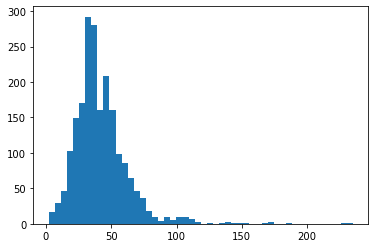

Plot of Label distribution


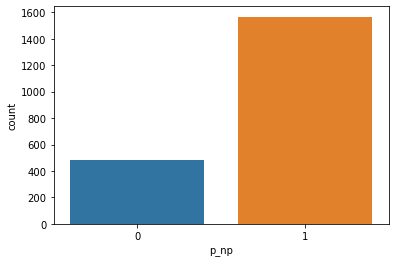

In [10]:
plot_data_statistics(bbbp_csv, smiles_col_name='smiles', label_col_name='p_np', task_type='classification')

In [11]:
process_dataset(bbbp_csv, smiles_col_name='smiles', label_col_name='p_np', max_len=100, dataset_name='bbbp')

>>> Start processing dataset..
Converting error at 59:O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
Converting error at 61:c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
Converting error at 391:Cc1nc(sc1)\[NH]=C(\N)N
Converting error at 519:c1(CC(N2[C@H](CN(CC2)C(=O)C)C[N@]2CC[C@H](O)C2)=O)ccc(N(=O)=O)cc1
Converting error at 541:c1(CC(N2[C@H](CN(CC2)C(=O)C)C[N@]2CC[C@H](O)C2)=O)cc(ccc1)N(=O)=O
Converting error at 614:s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
Converting error at 642:c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
Converting error at 645:n1c(csc1\[NH]=C(\N)N)c1ccccc1
Converting error at 646:n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
Converting error at 647:n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
Converting error at 648:n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
Converting error at 649:s1cc(nc1\[NH]=C(\N)N)C
Converting error at 685:c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
Converting error at 1417:NC(=N)c1ccc(o1)c2ccccc2N(=O)=O
Dataset written in ./dataset_pickles as python pickle files
- ./dataset_pi

## Lipophilicity
regression

In [12]:
pd.read_csv("./dataset/lipophilicity/raw/Lipophilicity.csv")

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


In [13]:
lipo_csv = "./dataset/lipophilicity/raw/Lipophilicity.csv"

Histogram of SELFIES length in the dataset


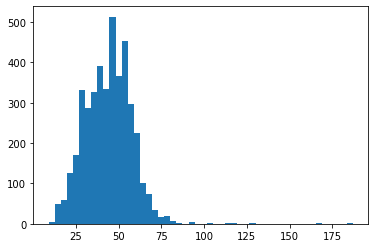

Plot of Label distribution


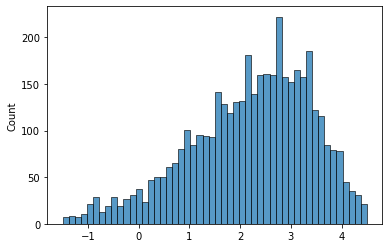

In [14]:
plot_data_statistics(lipo_csv, smiles_col_name='smiles', label_col_name='exp', task_type='regression')

In [15]:
process_dataset(lipo_csv, smiles_col_name='smiles', label_col_name='exp', max_len=100, dataset_name='lipo')

>>> Start processing dataset..
Dataset written in ./dataset_pickles as python pickle files
- ./dataset_pickles/symbol2idx_lipo.pickle
- ./dataset_pickles/lipo_data.pickle
- ./dataset_pickles/lipo_label.pickle
>>> Finished processing.
